In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from torch.autograd import Variable
from math import exp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Mounted at /content/drive


Text(0.5, 1.0, 'Moving Image')

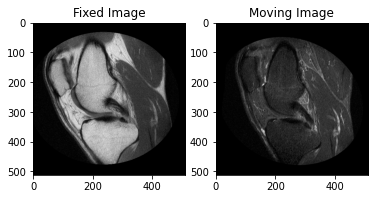

In [3]:
from google.colab import drive
drive.mount('/content/drive')

I = io.imread("/content/drive/My Drive/MM803/Assignment2/knee1.bmp").astype(np.float32)/255.0 # fixed image
J = io.imread("/content/drive/My Drive/MM803/Assignment2/knee2.bmp").astype(np.float32)/255.0 # moving image

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I,cmap="gray")
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J,cmap="gray")
plt.title("Moving Image")

In [4]:
L = 6 # Gaussian pyramid level
downscale = 2.0 # downscale factor for the gaussian pyramid
pyramid_I = tuple(pyramid_gaussian(I, downscale=downscale, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=downscale, multichannel=False))

# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in range(L):
  I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
  I_lst.append(I_)
  J_lst.append(J_)
  h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]
  ind_ = torch.randperm(h_*w_).to(device)
  ind_lst.append(ind_)

  print(h_,w_,len(ind_))
  h_lst.append(h_)
  w_lst.append(w_)

  y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
  y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
  xy_ = torch.stack([x_,y_],2)
  xy_lst.append(xy_)

512 512 262144
256 256 65536
128 128 16384
64 64 4096
32 32 1024
16 16 256


In [5]:
class HomographyNet(nn.Module):
  def __init__(self):
    super(HomographyNet, self).__init__()
    # perspective transform basis matrices

    self.B = torch.zeros(8,3,3).to(device)
    self.B[0,0,2] = 1.0
    self.B[1,1,2] = 1.0
    self.B[2,0,1] = 1.0
    self.B[3,1,0] = 1.0
    self.B[4,0,0], self.B[4,1,1] = 1.0, -1.0
    self.B[5,1,1], self.B[5,2,2] = -1.0, 1.0
    self.B[6,2,0] = 1.0
    self.B[7,2,1] = 1.0

    self.v = torch.nn.Parameter(torch.zeros(8,1,1).to(device), requires_grad=True)

  def forward(self):
    return MatrixExp(self.B,self.v)

def MatrixExp(B,v):
    C = torch.sum(B*v,0)
    A = torch.eye(3).to(device)
    H = torch.eye(3).to(device)
    for i in torch.arange(1,10):
        A = torch.mm(A/i,C)
        H = H + A
    return H

In [6]:
def PerspectiveWarping(I, H, xv, yv):
  # apply transformation in the homogeneous coordinates
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J

In [7]:
def ncc_val(I,J):
  I_mean = torch.mean(I)
  J_mean = torch.mean(J)
  I_std = torch.std(I)
  J_std = torch.std(J)
  return torch.mean((I-I_mean)*(J-J_mean)/(I_std*J_std))

In [8]:
def multi_resolution_NCC_loss():
  loss=0.0
  for s in np.arange(L-1,-1,-1):
    Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0).unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
    ncc_value = ncc_val(I_lst[s], Jw_)
    loss = loss - (1. / L) * ncc_value
  #print(histogram_mutual_information(I_lst[s].cpu().detach().numpy(), Jw_.cpu().detach().numpy()))
  return loss, ncc_value

In [9]:
homography_net = HomographyNet().to(device)
optimizer = optim.Adam([{'params': homography_net.v, 'lr': 1e-4}], amsgrad=True)

for itr in range(2200):
  optimizer.zero_grad()
  loss,ncc_value = multi_resolution_NCC_loss()
  if itr%200 == 0:
    print("Itr:",itr,"NCC value:","{:.4f}".format(ncc_value))
    print("NCC loss:", "{:.4f}".format(loss))
  loss.backward()
  optimizer.step()
print("Itr:",itr+1,"NCC value:","{:.4f}".format(ncc_value))

Itr: 0 NCC value: 0.5605
NCC loss: -0.6216
Itr: 200 NCC value: 0.6044
NCC loss: -0.6635
Itr: 400 NCC value: 0.6164
NCC loss: -0.6770
Itr: 600 NCC value: 0.6205
NCC loss: -0.6811
Itr: 800 NCC value: 0.6233
NCC loss: -0.6838
Itr: 1000 NCC value: 0.6250
NCC loss: -0.6857
Itr: 1200 NCC value: 0.6275
NCC loss: -0.6878
Itr: 1400 NCC value: 0.6299
NCC loss: -0.6905
Itr: 1600 NCC value: 0.6375
NCC loss: -0.6964
Itr: 1800 NCC value: 0.6648
NCC loss: -0.7095
Itr: 2000 NCC value: 0.6804
NCC loss: -0.7150
Itr: 2200 NCC value: 0.6852


Mutual information before registration: 0.5551
Mutual information after registration: 0.8347
Transformation matrix:
[[ 0.9875346  -0.09820149  0.04750895]
 [ 0.18882486  0.96412265  0.05781288]
 [-0.02036441  0.01305608  1.0298076 ]]



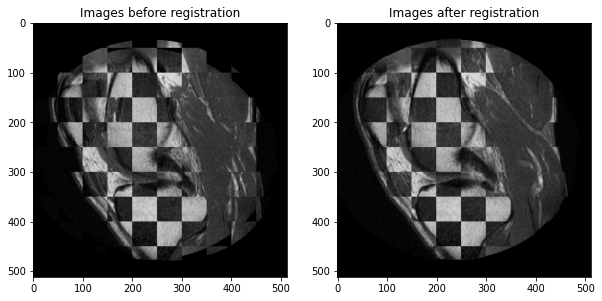

In [10]:
def histogram_mutual_information(image1, image2):
  hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
  pxy = hgram / float(np.sum(hgram))
  px = np.sum(pxy, axis=1)
  py = np.sum(pxy, axis=0)
  px_py = px[:, None] * py[None, :]
  nzs = pxy > 0
  return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
  
I_t = torch.tensor(I).to(device)
J_t = torch.tensor(J).to(device)
H = homography_net()
J_w = PerspectiveWarping(J_t.unsqueeze(0).unsqueeze(0), H, xy_lst[0][:, :, 0], xy_lst[0][:, :, 1]).squeeze()

D = J_t - I_t
D_w = J_w - I_t

print("Mutual information before registration:", "{:.4f}".format(histogram_mutual_information(I, J_t.cpu().detach().numpy())))
print("Mutual information after registration:", "{:.4f}".format(histogram_mutual_information(I, J_w.cpu().detach().numpy())))

print("Transformation matrix:")
print(H.cpu().detach().numpy())
print("")

Ra = I_t.clone()
Rb = I_t.clone()
b = 50
for i in torch.arange(0, I_t.shape[0] / b, 1).int():
  for j in torch.arange(i % 2, np.floor(I_t.shape[1] / b), 2).int():
    Rb[i * b:(i + 1) * b, j * b:(j + 1) * b] = J_t[i * b:(i + 1) * b, j * b:(j + 1) * b].clone()
    Ra[i * b:(i + 1) * b, j * b:(j + 1) * b] = J_w[i * b:(i + 1) * b, j * b:(j + 1) * b].clone()

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(Rb.cpu().data, cmap="gray")
plt.title("Images before registration")
fig.add_subplot(1, 2, 2)
plt.imshow(Ra.cpu().data, cmap="gray")
plt.title("Images after registration")
plt.show()